#Cognitive and Neural Dynamics Lab Tutorials
##Spike Field Coherence

#####Torben Noto 2015

#####The timing of neuronal firing is not random. It is often biased by oscillations in the local field. 
For a long time people thought that the **more a neuron fired** - the more signal it communicated (rate coding). There is now evidence that a neuron has to fire **at the right time** to effectively communicate to postsynaptic neurons.
Neural firing often times up with **neural oscillations**, in a process known as **spike field coherence**. This is something that we are very interested in at the Cognitive and Neural Dynamics Lab at UCSD. 

This ipython notebook uses the hc-2 dataset from crcns.org

This data was collected and shared by the Buzsáki lab at NYU.
In this dataset, we have data from local field potentials (LFP) as well as firing of individual neurons in rat CA2, part of the hippocampus.
This affords us a perfect opportunity to explore how spiking interacts with the local field.

In this notebook I will show, in several ways, that there is clearly a relationship between spiking and the phase of this oscillation in these data.

In [2]:
%config InlineBackend.figure_format = 'retina'
%pylab inline
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import scipy.io
import scipy.signal
from scipy.signal import butter, filtfilt, hilbert

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Importing Buzsáki's data from a local source
# This data can be downloaded from www.github.com/voytekresearch/Tutorials
fpath = ('/Users/Torben/Desktop/Voytek_Things/datasets/')
filename = 'lfp_spiketimes_ec013.527.mat'
filename = os.path.join(fpath+filename)

data = sp.io.loadmat(filename)

lfpsrate = data['srate']; #sampling rate for LFP
spikesrate = data['spksrate']; #sampling rate for spikes (different than LFP sampling rate)


lfp = data['data']; # Local field potential recorded by 31 shanks
spikes = data['T']; # Times of spikes

lfpspiketimes = np.ceil(spikes / (spikesrate/lfpsrate)); #Converting spike timing to srate of LFP.
lfpspiketimes = lfpspiketimes.astype(int);

lfp = mean(lfp,0); #Average LFP of all shanks

#####So let's take a step back.
Neural activity oscillates. 
That is to say there are relatively predictable periods of high and low amplitude across certain wavelengths.
In CA2, where this data is recorded from, scientists typically observe a clear oscillation at around 4-8 Hz.
See cell below:


One Second of Local field potential in CA2


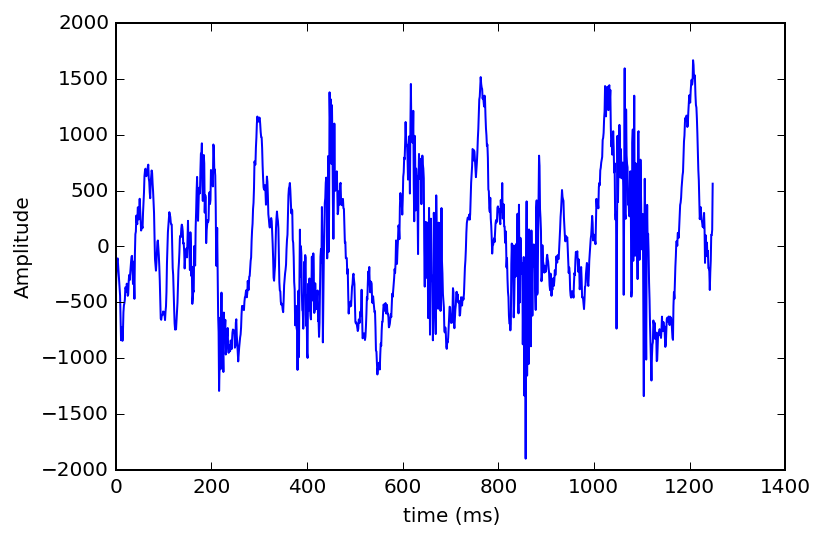

In [5]:
plot(lfp[1:lfpsrate]) #One shank
ylabel('Amplitude')
xlabel('time (ms)')
print 'One Second of Local field potential in CA2'


As you can see, in this recording, there are about 8 clear peaks in one second of data.

With spike field coupling, we want to see if spiking of individual neurons lines up with a certain part of the phase.
There are many ways to visualize this. 

- First, I'll show a simple, but rough explanation of this.
- Second, I'll show you two complex, but accurate visualizations of spike field coupling.
- Last, I'll show you how to calculate r and p values for spike field coupling.


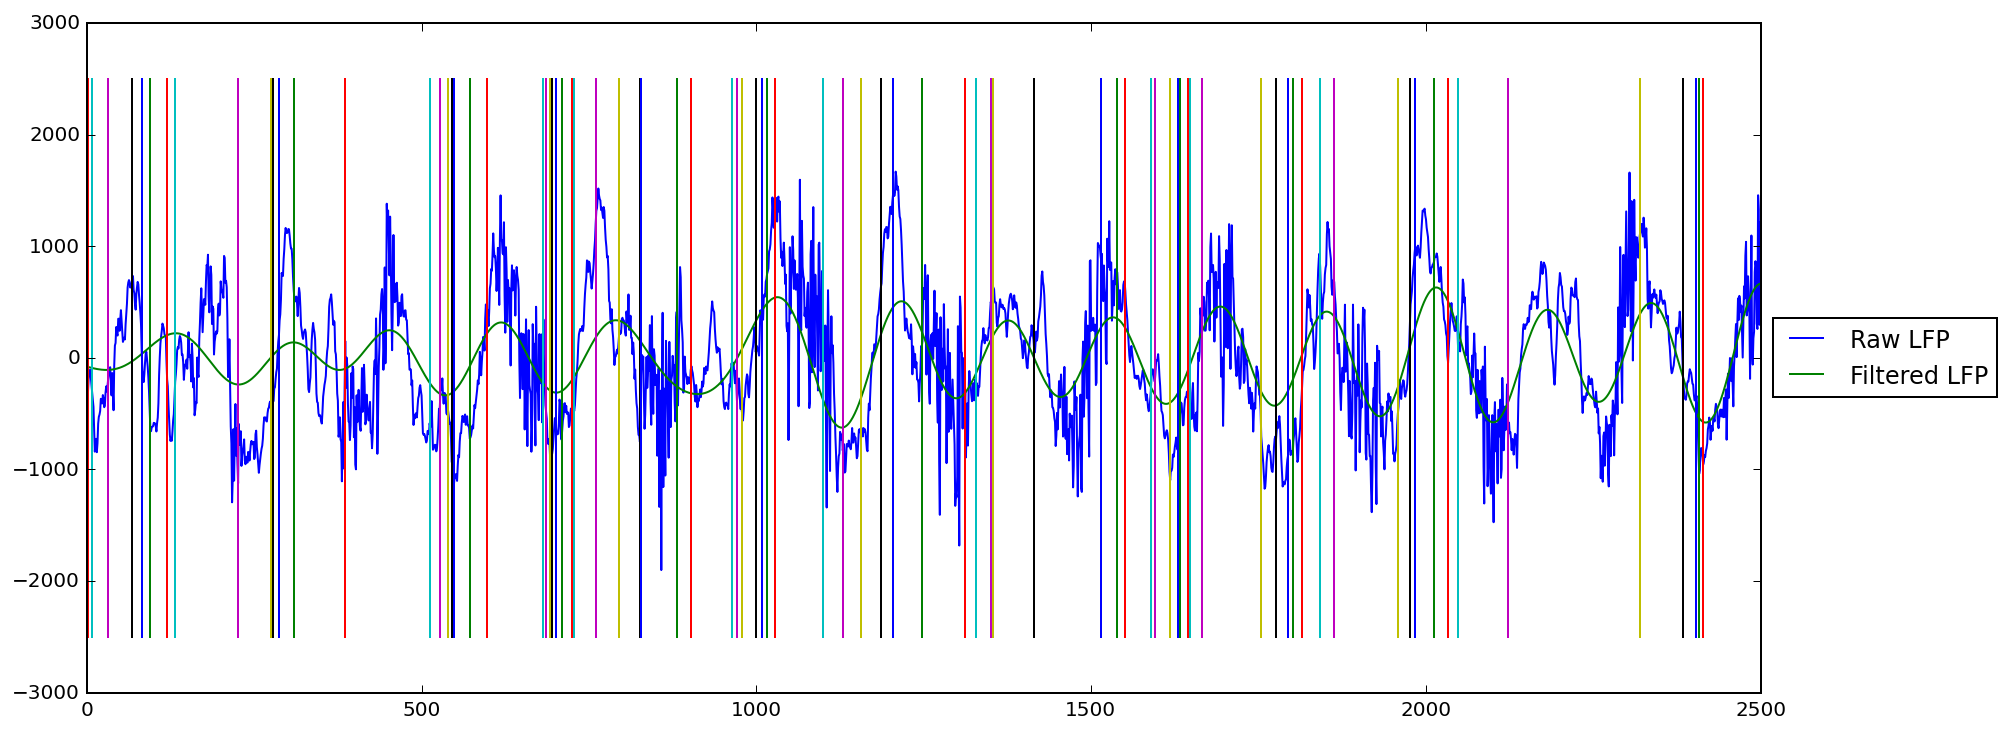

In [10]:
#helpful filtering functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs #nyquist frequency
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, mydata)
    return y


filtdat = butter_bandpass_filter(lfp,4,8,lfpsrate); #Filtering the LFP data

figure(figsize = (15,6))
plot(lfp[0:lfpsrate*2],label = 'Raw LFP')


plot(filtdat[0:lfpsrate*2],label = 'Filtered LFP')

for spike in lfpspiketimes[0:85]:
    plot([spike, spike],[-2500,2500])
legend(loc='center left', bbox_to_anchor=(1, 0.5))


In the graph above we're visualizing 3 things in the first 3 seconds of the data:
1. The Raw LFP signal
2. The LFP signal filtered to the 4-8 Hz band
3. Timing of individual spikes

I hope you'll agree on two things about the data: 1) The filtered signal matches up nicely with the raw signal, and 2) spike times seem to be biased to happen just after the **troughs** of the filtered signal.
That is to say the **spikes** are **coupled** to the phase of the local **field**.

Another way of looking at this is by using the **spike triggered average** (below)

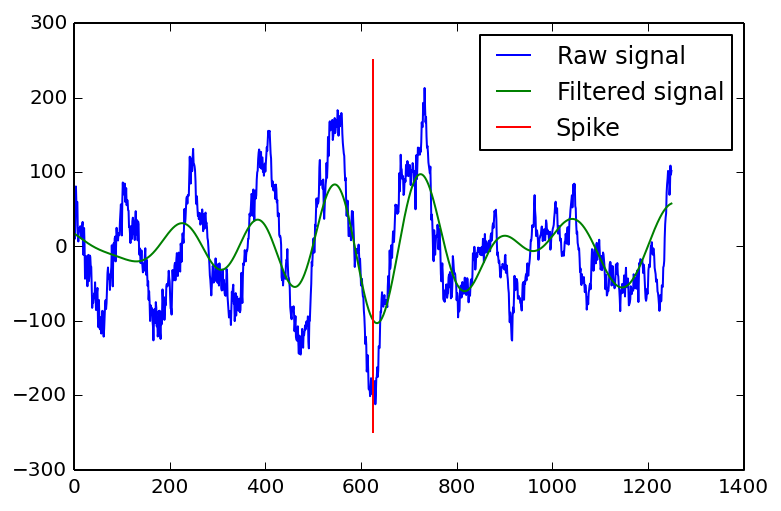

In [15]:
spike_triggered_average_mat = np.zeros((100,1250)) #What does the lfp look like when spikes happen?
spike_triggered_average_mat_filt = np.zeros((100,1250)) #What does the filtered data look like when spikes happen?

c=0;
for spike in lfpspiketimes[100:200]:
    spike_triggered_average_mat[c,:] = lfp[spike-625:spike+625:];
    spike_triggered_average_mat_filt[c,:] = filtdat[spike-625:spike+625:];
    c +=1;

spike_triggered_average = mean(spike_triggered_average_mat,0); #Average signal when spikes happen
spike_triggered_average_filt = mean(spike_triggered_average_mat_filt,0);#Average filtered signal when spikes happen

plot(spike_triggered_average,label = 'Raw signal')
plot(spike_triggered_average_filt,label = 'Filtered signal')
plot([626, 626],[-250,250],label = 'Spike')
legend()
    

So in the figure above, we're looking at what the Average LFP looks like every time there is a spike. If there was no relationship between spiking and the phase, we would just see noise. 

However, we see a clear tendancy for spikes to happen at a the trough of the oscillation. Any outliers are washed out by averaging over so many spikes.

Here's one more way we can visualize this effect:

In [16]:
#calculating the phase of filtered data. This might take a minute to run
hilbert_filt = sp.signal.hilbert(filtdat); 
angle_dat = angle(hilbert_filt); 

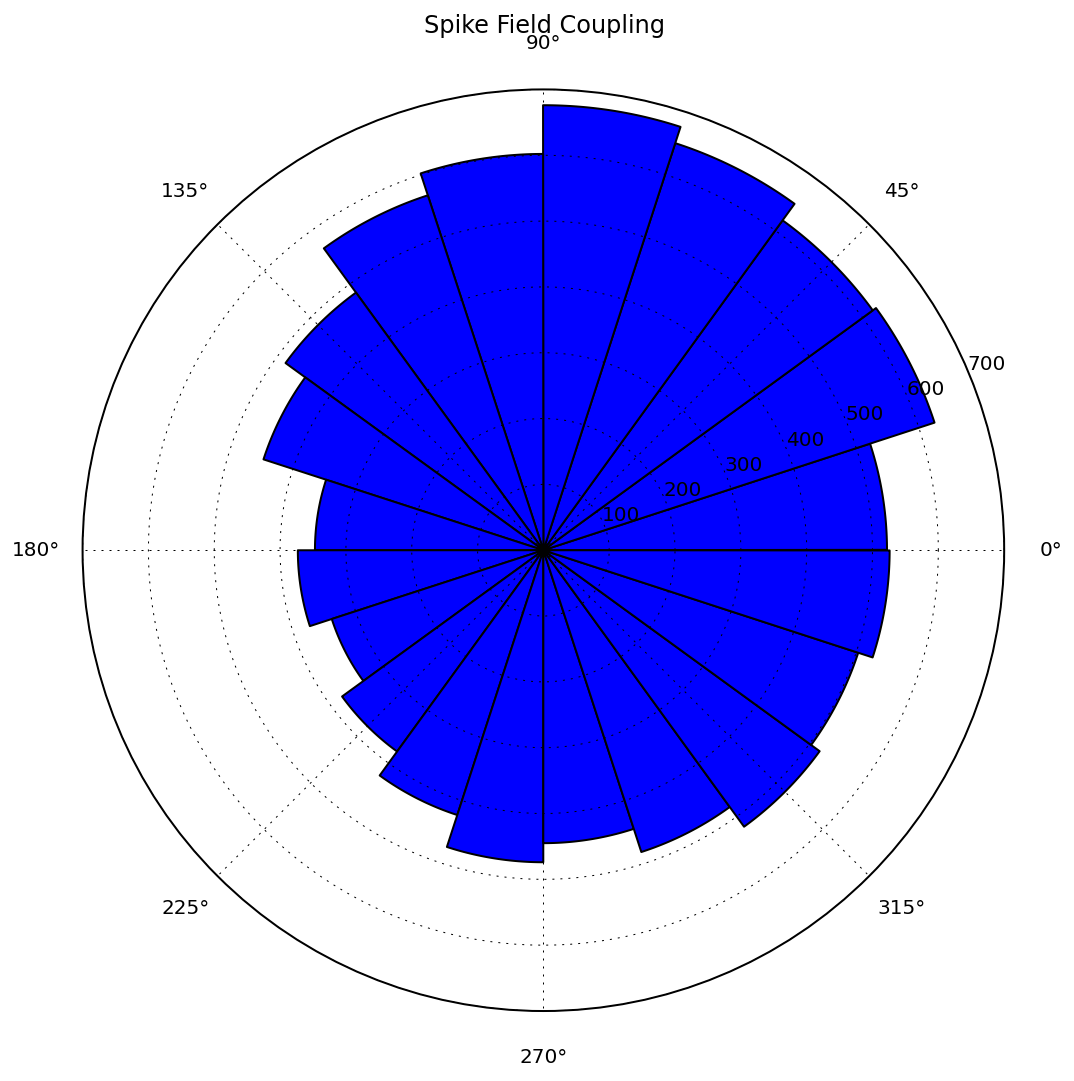

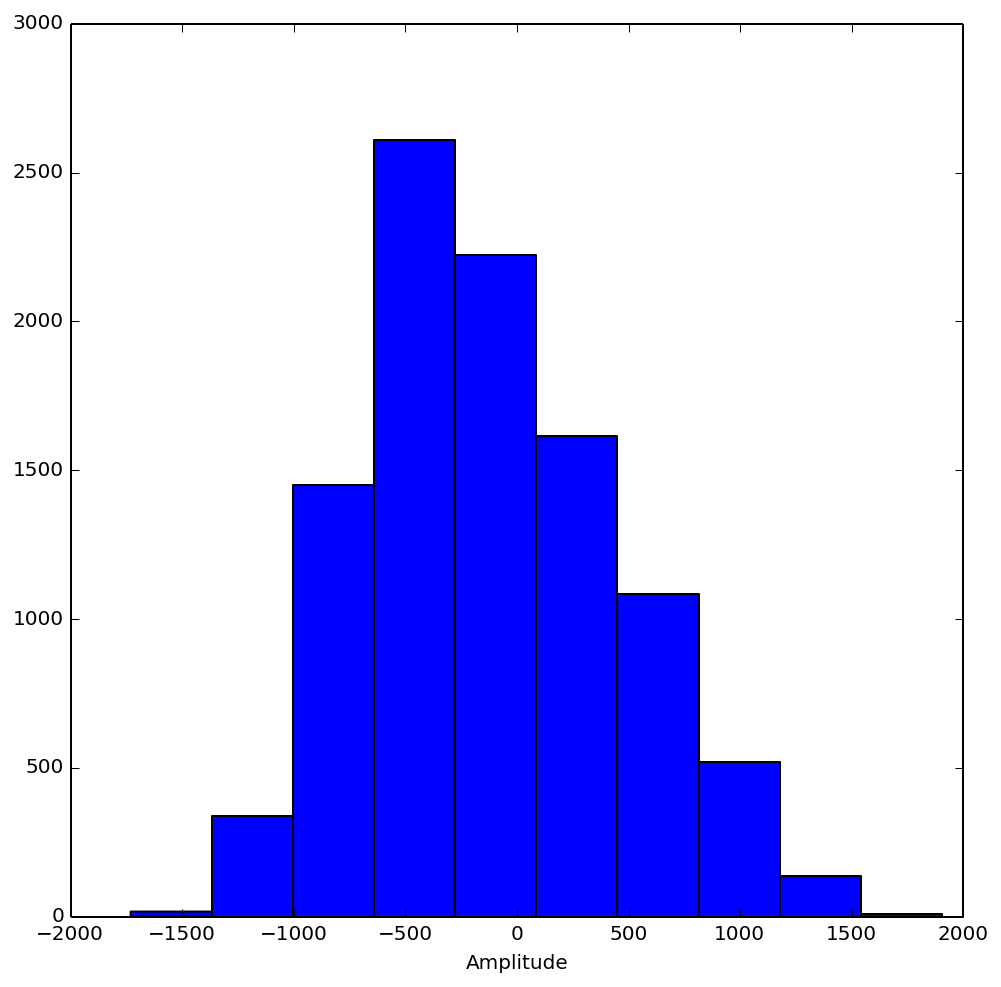

In [73]:
phases_at_spikes = np.zeros((10000));
amp_at_spikes = np.zeros((10000));

c=0;
for spike in lfpspiketimes[0:10000]:
    spike = int(spike);
    phases_at_spikes[c]= angle_dat[spike];
    amp_at_spikes[c]= lfp[spike];
    c +=1;
sfc =np.histogram(phases_at_spikes,20);
sfc_amp =np.histogram(amp_at_spikes);

bins= (sfc[1]+pi); 
bins = bins[:len(bins)-1];

fig = figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
bars = ax.bar(bins, sfc[0], width=bins[1]-bins[0], bottom=0.0)
plt.title('Spike Field Coupling');

fig = figure(figsize=(8,8))
hist(amp_at_spikes);
plt.xlabel('Amplitude');

The **rose plot** above shows that the timing of spikes is biased to happen at the 85 degree phase of the oscillation.
If there was no spike-field coupling, there would be no difference in the bars in all of the bins.

In the histogram below, we see that spikes seem to happen most when the amplitude of the LFP is about -500 mV.

In the cell below we will calculate a score that will tell us how much SFC is happening:

Phase Locking Value: 0.126516221712


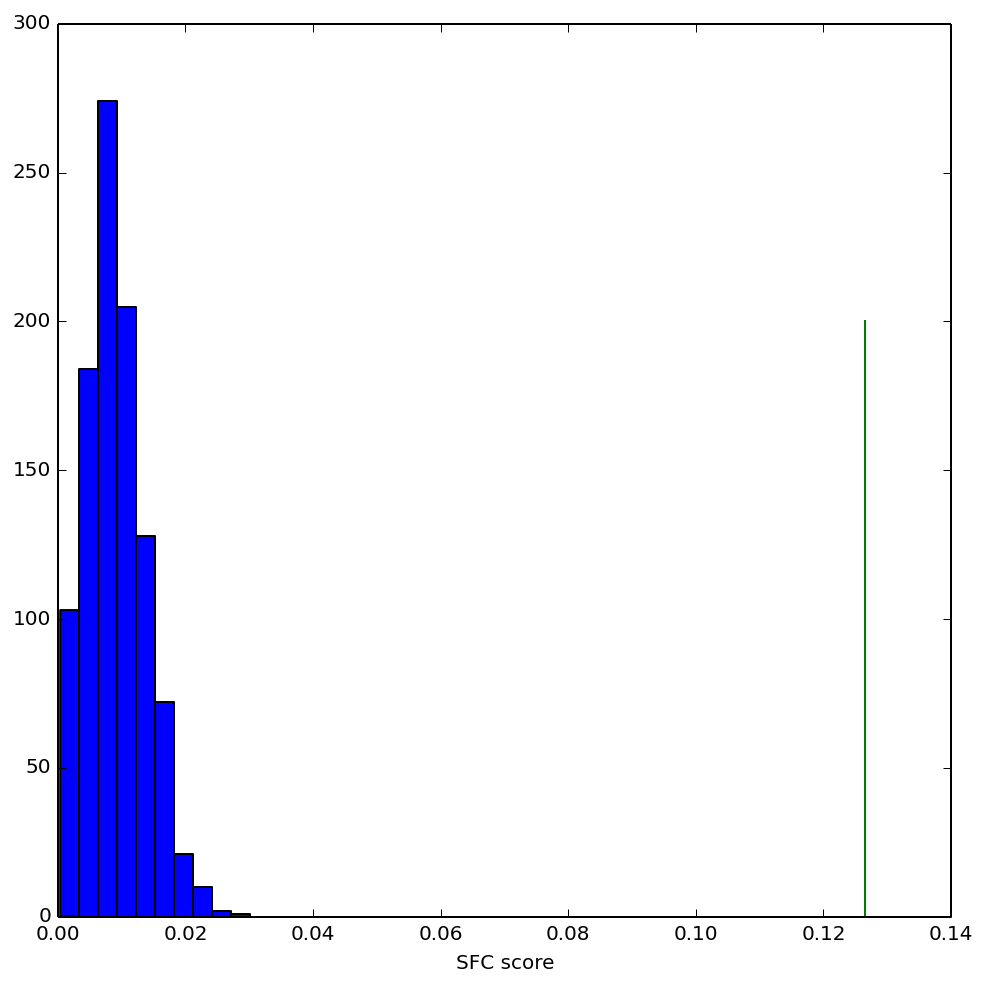

In [70]:
import random as rd

phase_locking_value= abs(sum(exp(1j*phases_at_spikes))/len(phases_at_spikes)); #fancy math
print 'Phase Locking Value: '+ str(phase_locking_value)

bootstrap_vals = zeros((1000));

#bootstraping significance value
for x in xrange(1000):
    random_phases = [ angle_dat[i] for i in rd.sample(xrange(len(angle_dat)), len(phases_at_spikes)) ]
    bootstrap_vals[x] = np.abs(np.sum(np.exp(np.dot(1j,random_phases)))/len(random_phases));
  
fig = figure(figsize=(8,8))
hist(bootstrap_vals)
plot([phase_locking_value, phase_locking_value],[0, 200])
xlabel('SFC score');

In the above cell, I calculated the spike field coupling. This score ranges from 0 (no SFC) to 1 (perfect SFC). This calculation doesn't tell us anything about the exact phase that spikes are coupled to but it tells us that there is some bias in the data for spikes to prefer a certain phase. However, the score we got is pretty low because this calculation of SFC gets lower scores as you increase the length of the time series you put in.

To prove that our 'low score' of 0.13 is significant, I used bootstrap statistics, shown in the histogram. I calculated SFC values of random points in the phase data 1000 times and plotted them compared to the real SFC value. You can think of this as a null hypothesis test. 

You can see that the real SFC value is higher than all 1000 SFC values with randomly shifted phase. This, along with all of the other figures demonstrates that the timing of spikes in these data is clearly related to the phase of the ongoing theta oscillation.